☝ # KÜTÜPHANELER

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Pandas display ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)


In [ ]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)


☝ AÇIKLAMALAR

FL_DATE                   : Uçuş tarihi.
AIRLINE                   : Havayolunun adı.
AIRLINE_DOT               : Havayolunun DOT (Ulaştırma Bakanlığı) tanımlayıcısı.
AIRLINE_COD E             : Havayoluna atanan kod (IATA/ICAO kodu olabilir).
DOT_CODE                  : DOT tanımlayıcısı.
FL_NUMBER                 : Uçuş numarası.
ORIGIN                    : Kalkış havaalanı kodu (genelde IATA).
ORIGIN_CITY               : Kalkış havaalanının bulunduğu şehir.
DEST                      : Varış havaalanı kodu (genelde IATA).
DEST_CITY                 : Varış havaalanının bulunduğu şehir.
CRS_DEP_TIME              : Planlanan kalkış saati.
DEP_TIME                  : Gerçek kalkış saati.
DEP_DELAY                 : Kalkış gecikmesi (dakika).
TAXI_OUT                  : Kalkışta pist başına taksi süresi (dakika).
WHEELS_OFF                : Uçağın tekerleklerinin yerden kesildiği saat.
WHEELS_ON                 : Uçağın tekerleklerinin piste değdiği saat.
TAXI_IN                   : İniş sonrası kapıya taksi süresi (dakika).
CRS_ARR_TIME              : Planlanan varış saati.
ARR_TIME                  : Gerçek varış saati. ARR_DELAY                 : Varış gecikmesi (dakika).
CANCELLED                 : Uçuş iptal durumu (1=iptal, 0=iptal değil).
CANCELLATION_CODE         : İptal nedeni kodu (varsa).
DIVERTED                  : Uçuşun başka bir meydana yönlendirilme durumu (1=divert, 0=hayır).
CRS_ELAPSED_TIME          : Planlanan toplam uçuş/kapıdan-kapıya süre (dakika).
ELAPSED_TIME              : Gerçekleşen toplam süre, kapıdan kapıya (dakika). AIR_TIME                  : Havada geçirilen süre (dakika).
 DISTANCE                  : Uçuş mesafesi (genellikle mil).
DELAY_DUE_CARRIER         : Havayolu (taşıyıcı) kaynaklı gecikme (dakika).
 DELAY_DUE_WEATHER         : Hava durumu kaynaklı gecikme (dakika).
 DELAY_DUE_NAS             : Ulusal Hava Sahası Sistemi (NAS) kaynaklı gecikme (dakika).
 DELAY_DUE_SECURITY        : Güvenlik kaynaklı gecikme (dakika).
 DELAY_DUE_LATE_AIRCRAFT   : Önceki seferden geç gelen uçak kaynaklı gecikme (dakika).

**☝ FONKSİYONLAR**

In [ ]:

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")

    print(dataframe.select_dtypes(include=["number"]).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def num_summary(dataframe, numerical_col, plot=False):
        quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
        print(dataframe[numerical_col].describe(quantiles).T)

        if plot:
            dataframe[numerical_col].hist(bins=20)
            plt.xlabel(numerical_col)
            plt.title(numerical_col)
            plt.show(block=True)

def cat_summary(dataframe, col_name, plot=False, top_n=20):
    counts = dataframe[col_name].value_counts()
    ratios = 100 * counts / len(dataframe)
    df_out = pd.DataFrame({col_name: counts, "Ratio (%)": ratios.round(2)})

    print(df_out.head(top_n))
    print("#" * 60)

    if plot:
        plt.figure(figsize=(12, 6))
        ax = sns.countplot(data=dataframe, x=col_name,
                           order=counts.index[:top_n])
        plt.xticks(rotation=45, ha="right")
        plt.title(f"{col_name} - Category Counts (Top {top_n})")
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',
                        (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='bottom', fontsize=9, color='black')
        plt.tight_layout()
        plt.show()

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col, observed=True)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def grab_col_names(dataframe, cat_th=13, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

# Calculate the proportion of missing data

def checkMissing(data,perc=0):
    """
    Takes in a dataframe and returns
    the percentage of missing value.
    """
    missing = [(i, data[i].isna().mean()*100) for i in data]
    missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
    missing = missing[missing.percentage > perc]
    print(missing.sort_values("percentage", ascending=False).reset_index(drop=True))

print("Proportion of missing data in columns")

def hhmm_to_hour(x):
    """CRS_DEP_TIME/CRS_ARR_TIME gibi HHMM alanlardan saat (0-23) döndürür."""
    if pd.isna(x):
        return np.nan
    try:
        xi = int(x)
        return xi // 100
    except Exception:
        return np.nan

def hhmm_to_minutes(x):
    """HHMM → toplam dakika (örn. 0830 -> 8*60+30=510)."""
    if pd.isna(x):
        return np.nan
    try:
        xi = int(x)
        return (xi // 100) * 60 + (xi % 100)
    except Exception:
        return np.nan

# ---------- Helpers ----------
def hhmm_to_parts(hhmm):
    """
    HHMM -> (hour, minute). Her türlü string/float/int/NaN girişi tolere eder.
    2460 gibi uç değerlerde mod işlemiyle normalize eder.
    """
    s = pd.Series(hhmm)
    # NaN -> "0000", sayı/str -> "HHMM" 4 haneye pad
    s = s.where(~s.isna(), other=0)
    s = s.astype(float).round().astype(int).astype(str).str.zfill(4)
    hh = s.str.slice(0, 2).astype(int) % 24
    mm = s.str.slice(2, 4).astype(int) % 60
    return hh, mm

def hhmm_to_datetime(fl_date, hhmm):
    """Temel dönüştürücü: FL_DATE + HH:MM (aynı gün)."""
    hh, mm = hhmm_to_parts(hhmm)
    base = pd.to_datetime(fl_date)
    return base + pd.to_timedelta(hh, unit="h") + pd.to_timedelta(mm, unit="m")

def make_planned_datetimes(df):
    """
    Planlanan kalkış/varış datetime'ları.
    CRS_ARR_TIME < CRS_DEP_TIME ise planlanan varış ertesi güne kaydırılır.
    """
    dep_dt = hhmm_to_datetime(df["FL_DATE"], df["CRS_DEP_TIME"])
    arr_dt = hhmm_to_datetime(df["FL_DATE"], df["CRS_ARR_TIME"])

    # Planlanan varış saat olarak kalkıştan küçükse → +1 gün (ertesi gün varış)
    dep_hh, _ = hhmm_to_parts(df["CRS_DEP_TIME"])
    arr_hh, _ = hhmm_to_parts(df["CRS_ARR_TIME"])
    need_next_day = arr_hh < dep_hh
    arr_dt = arr_dt.where(~need_next_day, arr_dt + pd.Timedelta(days=1))

    return dep_dt, arr_dt

def make_actual_datetimes(df, rollover_hours_dep=12, rollover_hours_arr=12):
    """
    Gerçek kalkış/varış datetime'ları.
    - Gerçek kalkış: planlı kalkışa göre rollover uygula.
    - Gerçek varış: planlı varışa göre rollover uygula.
    Not: CANCELLED/DIVERTED vb. durumlarda NaN kalır.
    """
    crs_dep_dt, crs_arr_dt = make_planned_datetimes(df)

    act_dep = hhmm_to_datetime(df["FL_DATE"], df["DEP_TIME"])
    act_arr = hhmm_to_datetime(df["FL_DATE"], df["ARR_TIME"])

    # Rollover: gerçek zaman planlı zamandan çok daha küçükse ertesi güne kaydır
    dep_roll = act_dep < (crs_dep_dt - pd.Timedelta(hours=rollover_hours_dep))
    arr_roll = act_arr < (crs_arr_dt - pd.Timedelta(hours=rollover_hours_arr))
    act_dep = act_dep.where(~dep_roll, act_dep + pd.Timedelta(days=1))
    act_arr = act_arr.where(~arr_roll, act_arr + pd.Timedelta(days=1))

    # İptal/divert satırlarında gerçekler NaN kalabilir; olduğu gibi bırakıyoruz.
    return act_dep, act_arr, crs_dep_dt, crs_arr_dt

def compute_delay_minutes(plan_dt, actual_dt):
    """
    (actual - planned) dakika. NaN'lar aynen döner.
    Negatif değer = erken kalkış/varış.
    """
    delta = (actual_dt - plan_dt)
    return delta.dt.total_seconds() / 60.0

Proportion of missing data in columns


# **☝ GENEL RESİM **

 ##
�
�
 Step 1: Load Dataset and Initial Inspection

In [ ]:
df_ = pd.read_csv("/content/flights_sample_3m.csv")

In [ ]:
df = df_.copy()

In [ ]:
df.shape

(3000000, 32)

In [ ]:
check_df(df)

##################### Shape #####################
(3000000, 32)
##################### Types #####################
FL_DATE                     object
AIRLINE                     object
AIRLINE_DOT                 object
AIRLINE_CODE                object
DOT_CODE                     int64
FL_NUMBER                    int64
ORIGIN                      object
ORIGIN_CITY                 object
DEST                        object
DEST_CITY                   object
CRS_DEP_TIME                 int64
DEP_TIME                   float64
DEP_DELAY                  float64
TAXI_OUT                   float64
WHEELS_OFF                 float64
WHEELS_ON                  float64
TAXI_IN                    float64
CRS_ARR_TIME                 int64
ARR_TIME                   float64
ARR_DELAY                  float64
CANCELLED                  float64
CANCELLATION_CODE           object
DIVERTED                   float64
CRS_ELAPSED_TIME           float64
ELAPSED_TIME               float64
AIR_TIME   

In [ ]:
df.isnull().sum().sort_values(ascending=False)

,0
CANCELLATION_CODE,2920860
DELAY_DUE_LATE_AIRCRAFT,2466137
DELAY_DUE_CARRIER,2466137
DELAY_DUE_SECURITY,2466137
DELAY_DUE_NAS,2466137
DELAY_DUE_WEATHER,2466137
ARR_DELAY,86198
ELAPSED_TIME,86198
AIR_TIME,86198
WHEELS_ON,79944


In [ ]:
df.head(2)

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",1155,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,NaN,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",2120,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,NaN,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df["FL_DATE"] =pd.to_datetime(df["FL_DATE"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 32 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   FL_DATE                  datetime64[ns]
 1   AIRLINE                  object        
 2   AIRLINE_DOT              object        
 3   AIRLINE_CODE             object        
 4   DOT_CODE                 int64         
 5   FL_NUMBER                int64         
 6   ORIGIN                   object        
 7   ORIGIN_CITY              object        
 8   DEST                     object        
 9   DEST_CITY                object        
 10  CRS_DEP_TIME             int64         
 11  DEP_TIME                 float64       
 12  DEP_DELAY                float64       
 13  TAXI_OUT                 float64       
 14  WHEELS_OFF               float64       
 15  WHEELS_ON                float64       
 16  TAXI_IN                  float64       
 17  CRS_ARR_TIME             in

In [ ]:
df["FL_DATE"].head()

,FL_DATE
0,2019-01-09
1,2022-11-19
2,2022-07-22
3,2023-03-06
4,2020-02-23


In [ ]:
# 1. Sayıları 4 basamaklı stringe çeviriyoruz (5 -> 0005, 55 -> 0055, 645 -> 0645)
df["CRS_DEP_TIME"] = df["CRS_DEP_TIME"].astype(str).str.zfill(4)

# 2. Saat ve dakikayı ayırıyoruz
df["DEP_HOUR"] = df["CRS_DEP_TIME"].str[:2].astype(int)
df["DEP_MIN"] = df["CRS_DEP_TIME"].str[2:].astype(int)

# 3. Datetime tipine çeviriyoruz
df["CRS_DEP_TIME"] = pd.to_datetime(df["CRS_DEP_TIME"], format="%H%M").dt.time

print(df)


           FL_DATE                 AIRLINE                 AIRLINE_DOT AIRLINE_CODE  DOT_CODE  FL_NUMBER ORIGIN          ORIGIN_CITY DEST              DEST_CITY CRS_DEP_TIME  DEP_TIME  DEP_DELAY  TAXI_OUT  WHEELS_OFF  WHEELS_ON  TAXI_IN  CRS_ARR_TIME  ARR_TIME  ARR_DELAY  CANCELLED CANCELLATION_CODE  DIVERTED  CRS_ELAPSED_TIME  ELAPSED_TIME  AIR_TIME  DISTANCE  DELAY_DUE_CARRIER  DELAY_DUE_WEATHER  DELAY_DUE_NAS  DELAY_DUE_SECURITY  DELAY_DUE_LATE_AIRCRAFT  DEP_HOUR  DEP_MIN
0       2019-01-09   United Air Lines Inc.   United Air Lines Inc.: UA           UA     19977       1562    FLL  Fort Lauderdale, FL  EWR             Newark, NJ     11:55:00    1151.0       -4.0      19.0      1210.0     1443.0      4.0          1501    1447.0      -14.0        0.0               NaN       0.0             186.0         176.0     153.0    1065.0                NaN                NaN            NaN                 NaN                      NaN        11       55
1       2022-11-19    Delta Air Lines In

In [ ]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DEP_HOUR,DEP_MIN
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",11:55:00,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,NaN,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN,11,55
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",21:20:00,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,NaN,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN,21,20
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",09:54:00,1000.0,6.0,20.0,1020.0,1247.0,5.0,1252,1252.0,0.0,0.0,NaN,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN,9,54
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",16:09:00,1608.0,-1.0,27.0,1635.0,1844.0,9.0,1829,1853.0,24.0,0.0,NaN,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0,16,9
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",18:40:00,1838.0,-2.0,15.0,1853.0,2026.0,14.0,2041,2040.0,-1.0,0.0,NaN,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN,18,40


In [ ]:
df["YEAR"] = df["FL_DATE"].dt.year

In [ ]:
df["MONTH"] = df["FL_DATE"].dt.month

In [ ]:
df["DAYOFWEEK"] = df["FL_DATE"].dt.dayofweek

# **☝ 😇 DEstribution of Departure Delay**

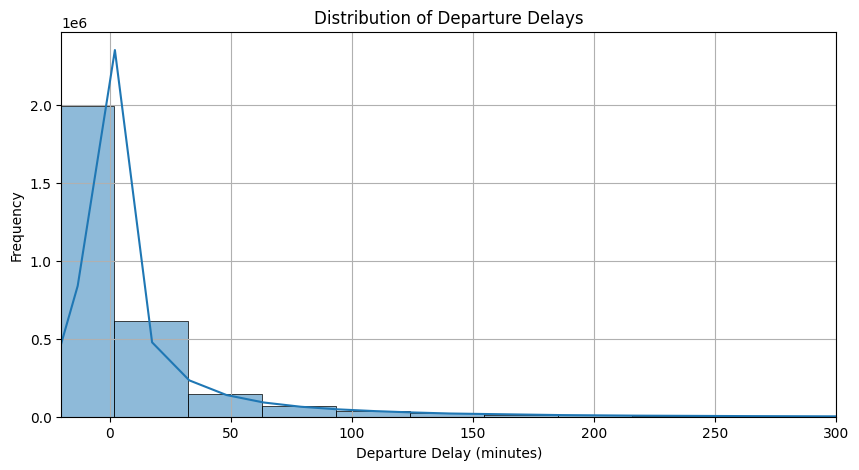

In [ ]:
 plt.figure(figsize=(10, 5))
 sns.histplot(df['DEP_DELAY'], bins=100, kde=True)
 plt.title('Distribution of Departure Delays')
 plt.xlabel('Departure Delay (minutes)')
 plt.ylabel('Frequency')
 plt.xlim(-20, 300)
 plt.grid(True)
 plt.show()

☝ ☝ Average Delay by Day of the Week

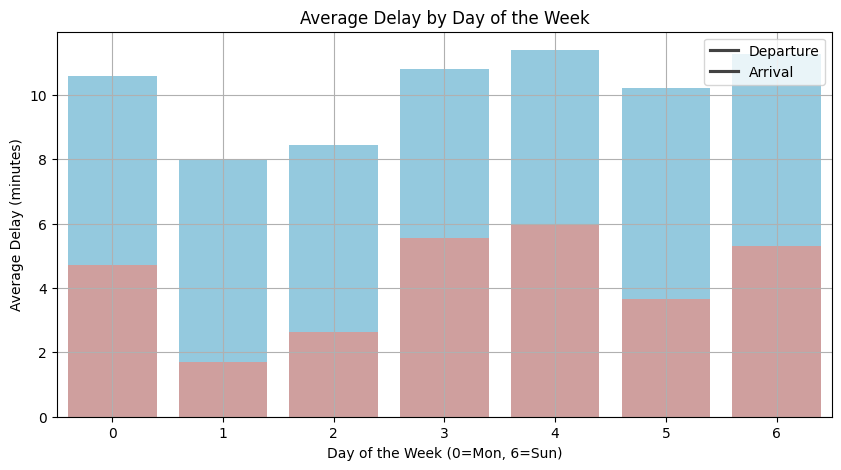

In [ ]:
dow_delay = df.groupby('DAYOFWEEK')[['DEP_DELAY', 'ARR_DELAY']].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x='DAYOFWEEK', y='DEP_DELAY', data=dow_delay, label='DEP_DELAY', color='skyblue')
sns.barplot(x='DAYOFWEEK', y='ARR_DELAY', data=dow_delay, label='ARR_DELAY', color='salmon', alpha=0.7)
plt.title('Average Delay by Day of the Week')
plt.xlabel('Day of the Week (0=Mon, 6=Sun)')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.legend(['Departure', 'Arrival'])
plt.show()

  ☝ 😇  Top Airlines with Most Average Delay

/tmp/ipython-input-2389519591.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DEP_DELAY', y='AIRLINE', data=airline_delay, palette='Blues_r')


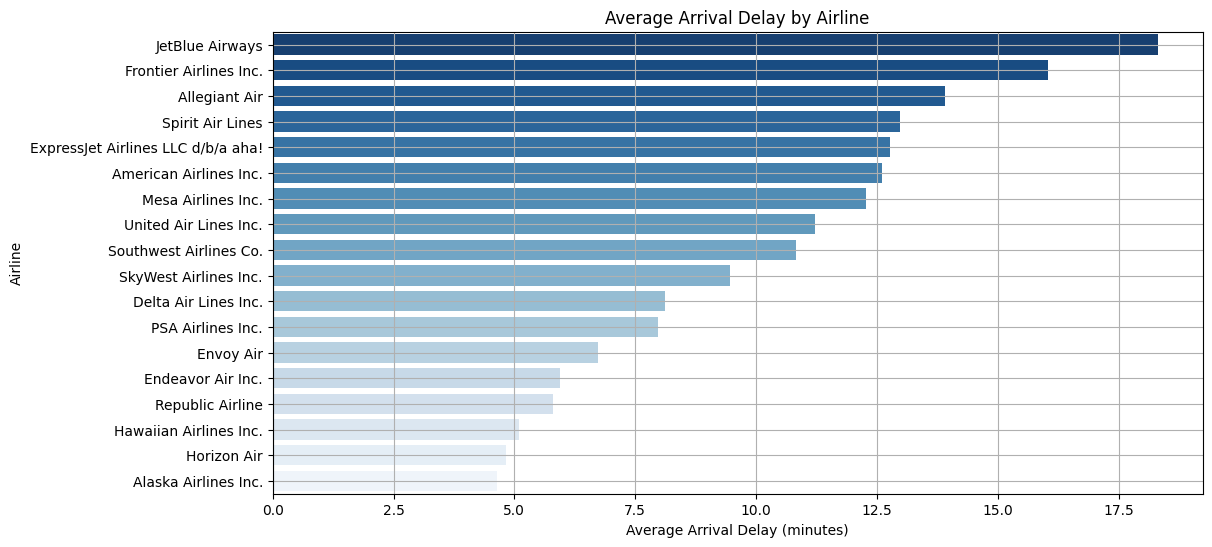

In [ ]:
airline_delay = df.groupby('AIRLINE')[['DEP_DELAY', 'ARR_DELAY']] \
 .mean().sort_values(by='DEP_DELAY', ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_DELAY', y='AIRLINE', data=airline_delay, palette='Blues_r')
plt.title('Average Arrival Delay by Airline')
plt.xlabel('Average Arrival Delay (minutes)')
plt.ylabel('Airline')
plt.grid(True)
plt.show()

** ☝  ☝  Top 10 Origin Airports with Most Average Departure Delay**

/tmp/ipython-input-2992880878.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DEP_DELAY', y='ORIGIN_CITY', data=origin_delay, palette='coolwarm')


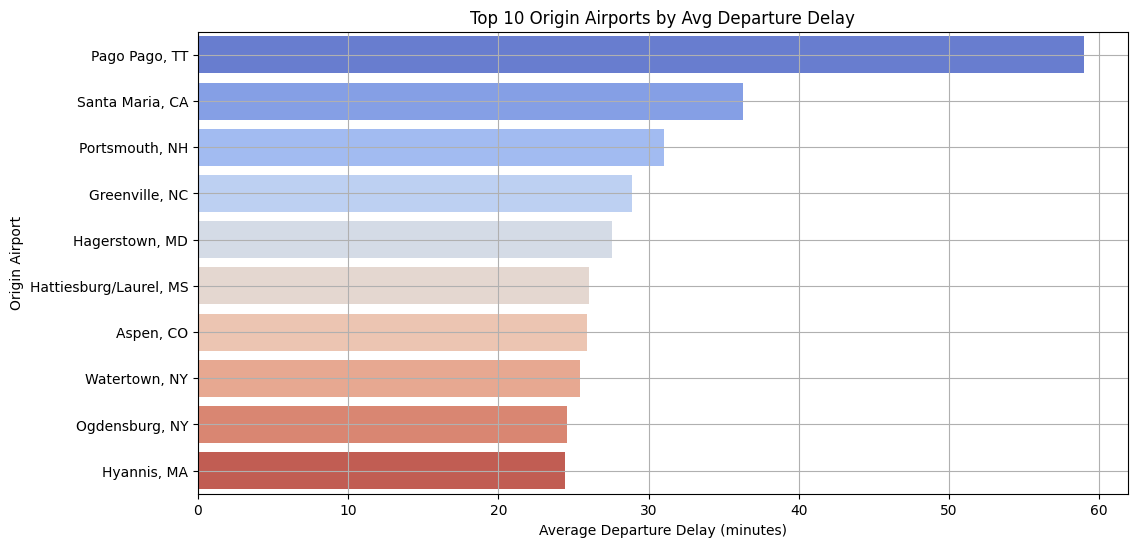

In [ ]:

origin_delay = df.groupby('ORIGIN_CITY')['DEP_DELAY'].mean().sort_values(ascending=False).head(10).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_DELAY', y='ORIGIN_CITY', data=origin_delay, palette='coolwarm')
plt.title('Top 10 Origin Airports by Avg Departure Delay')
plt.xlabel('Average Departure Delay (minutes)')
plt.ylabel('Origin Airport')
plt.grid(True)
plt.show()

In [ ]:
df["DEP_DELAY"].describe()

,DEP_DELAY
count,2.922356e+06
mean,1.012333e+01
std,4.925183e+01
min,-9.000000e+01
25%,-6.000000e+00
50%,-2.000000e+00
75%,6.000000e+00
max,2.966000e+03


 ☝ 🧕  Average Delay by Month and Airline

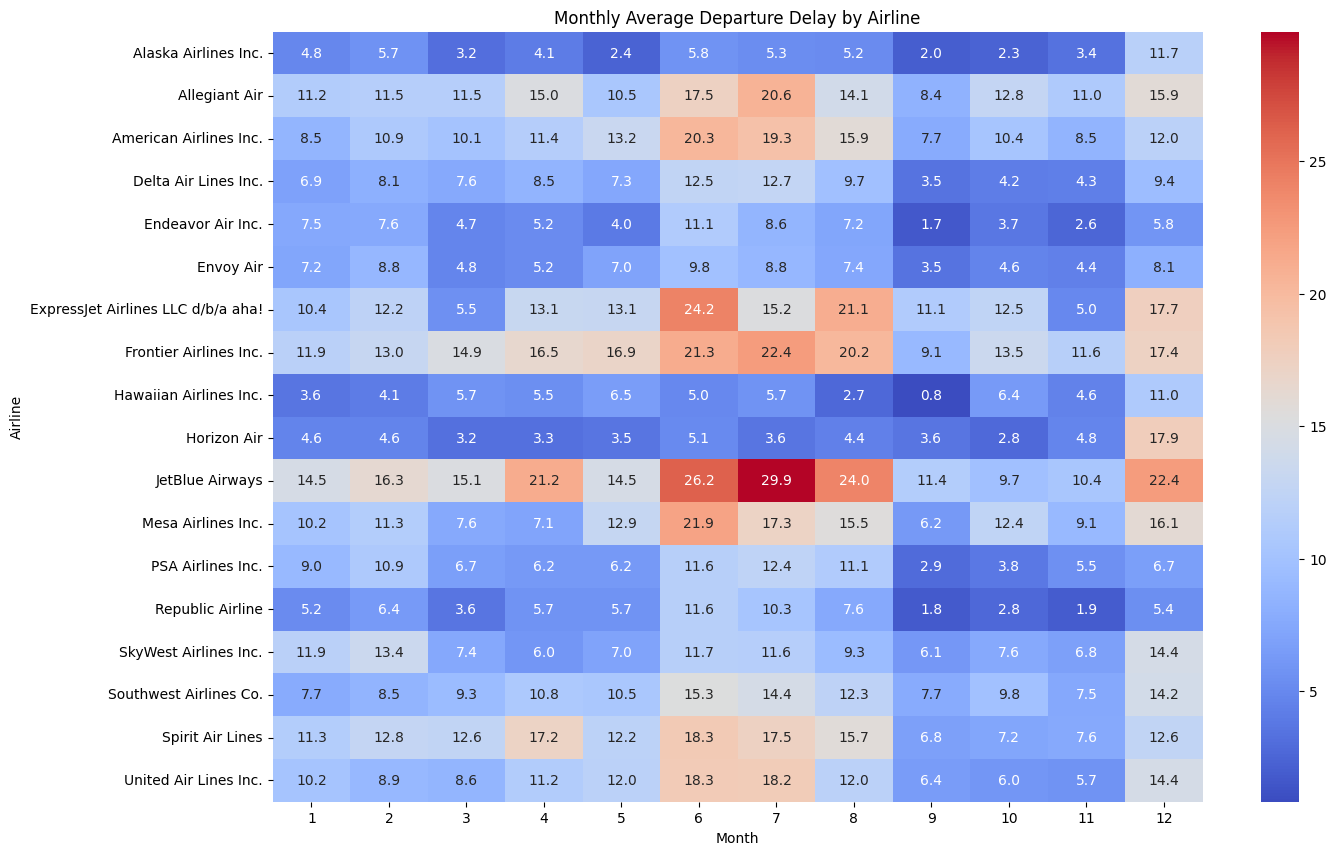

In [ ]:
pivot_delay = df.pivot_table(index='AIRLINE', columns='MONTH', values='DEP_DELAY', aggfunc='mean')
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_delay, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Monthly Average Departure Delay by Airline')
plt.xlabel('Month')
plt.ylabel('Airline')
plt.show()

  ☝  Compare Departure and Arrival Delays

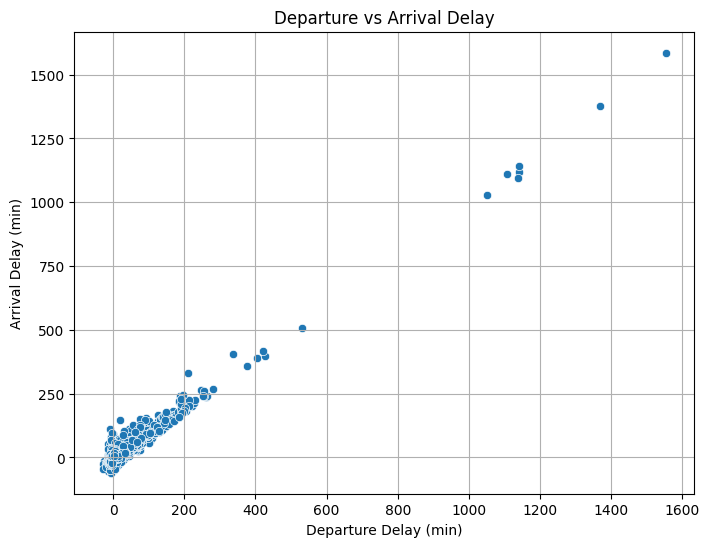

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='DEP_DELAY', y='ARR_DELAY', data=df.sample(5000))
plt.title('Departure vs Arrival Delay')
plt.xlabel('Departure Delay (min)')
plt.ylabel('Arrival Delay (min)')
plt.grid(True)
plt.show()

In [ ]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DEP_HOUR,DEP_MIN,YEAR,MONTH,DAYOFWEEK
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",11:55:00,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,NaN,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN,11,55,2019,1,2
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",21:20:00,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,NaN,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN,21,20,2022,11,5
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",09:54:00,1000.0,6.0,20.0,1020.0,1247.0,5.0,1252,1252.0,0.0,0.0,NaN,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN,9,54,2022,7,4
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",16:09:00,1608.0,-1.0,27.0,1635.0,1844.0,9.0,1829,1853.0,24.0,0.0,NaN,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0,16,9,2023,3,0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",18:40:00,1838.0,-2.0,15.0,1853.0,2026.0,14.0,2041,2040.0,-1.0,0.0,NaN,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN,18,40,2020,2,6


In [ ]:
df["ROUTE"] = df["ORIGIN"] + "_" + df["DEST"]

  Average Departure Delay by U.S. State

/tmp/ipython-input-3453144552.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DEP_DELAY', y='ROUTE', data=route_delay, palette='autumn')


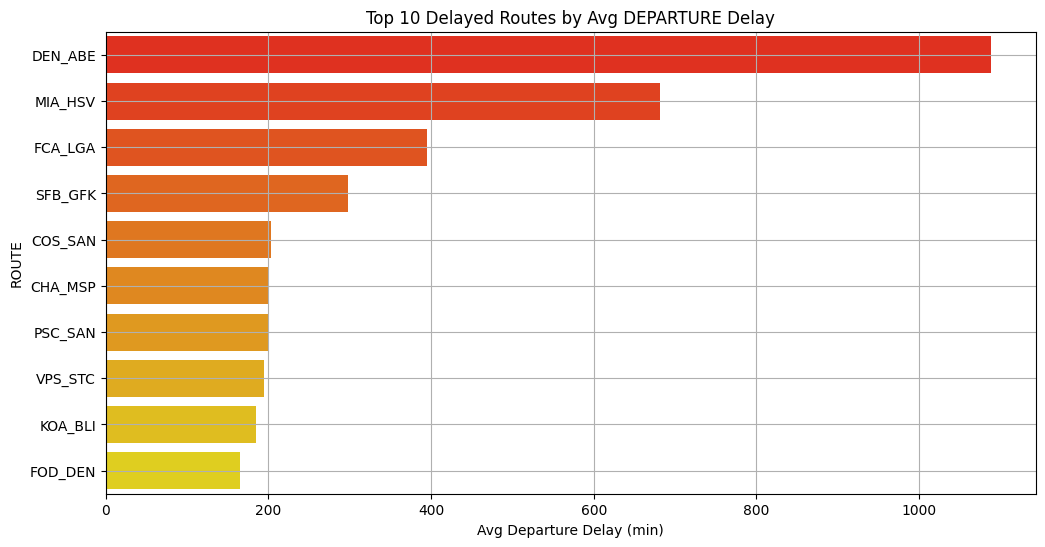

In [ ]:
route_delay = df.groupby('ROUTE')['DEP_DELAY'].mean().sort_values(ascending=False).head(10).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_DELAY', y='ROUTE', data=route_delay, palette='autumn')
plt.title('Top 10 Delayed Routes by Avg DEPARTURE Delay')
plt.xlabel('Avg Departure Delay (min)')
plt.ylabel('ROUTE')
plt.grid(True)
plt.show()

  ♾ Relationship Between Delay and Distance

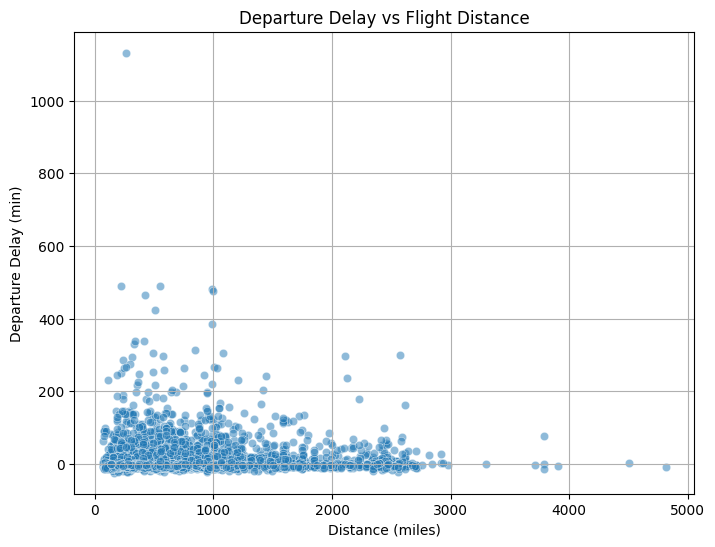

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='DISTANCE', y='DEP_DELAY', data=df.sample(5000), alpha=0.5)
plt.title('Departure Delay vs Flight Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Departure Delay (min)')
plt.grid(True)
plt.show()

 ☝Average Delay by Scheduled Departure Time Block

In [ ]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DEP_HOUR,DEP_MIN,YEAR,MONTH,DAYOFWEEK,ROUTE
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",11:55:00,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,NaN,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN,11,55,2019,1,2,FLL_EWR
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",21:20:00,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,NaN,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN,21,20,2022,11,5,MSP_SEA
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",09:54:00,1000.0,6.0,20.0,1020.0,1247.0,5.0,1252,1252.0,0.0,0.0,NaN,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN,9,54,2022,7,4,DEN_MSP
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",16:09:00,1608.0,-1.0,27.0,1635.0,1844.0,9.0,1829,1853.0,24.0,0.0,NaN,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0,16,9,2023,3,0,MSP_SFO
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",18:40:00,1838.0,-2.0,15.0,1853.0,2026.0,14.0,2041,2040.0,-1.0,0.0,NaN,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN,18,40,2020,2,6,MCO_DFW


In [ ]:
# Saat aralıklarını "HH:00-HH:59" formatında oluştur
df["TIMEBLOCK"] = df["CRS_DEP_TIME"].apply(lambda x: f"{x.hour:02d}:00-{x.hour:02d}:59")

df[["CRS_DEP_TIME", "TIMEBLOCK"]].head(10)




,CRS_DEP_TIME,TIMEBLOCK
0,11:55:00,11:00-11:59
1,21:20:00,21:00-21:59
2,09:54:00,09:00-09:59
3,16:09:00,16:00-16:59
4,18:40:00,18:00-18:59
5,10:10:00,10:00-10:59
6,10:10:00,10:00-10:59
7,16:43:00,16:00-16:59
8,05:30:00,05:00-05:59
9,21:25:00,21:00-21:59


/tmp/ipython-input-389326582.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DEP_DELAY', y='TIMEBLOCK', data=time_block_delay, palette='cividis')


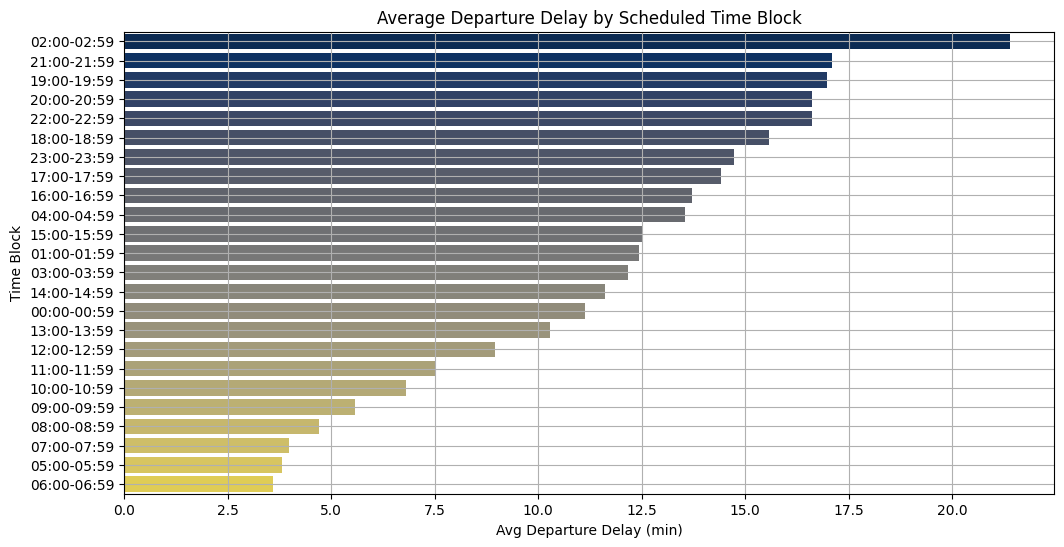

In [ ]:
time_block_delay = df.groupby('TIMEBLOCK')['DEP_DELAY'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_DELAY', y='TIMEBLOCK', data=time_block_delay, palette='cividis')
plt.title('Average Departure Delay by Scheduled Time Block')
plt.xlabel('Avg Departure Delay (min)')
plt.ylabel('Time Block')
plt.grid(True)
plt.show()

⁉   Delay Distribution by Delay Cause Type

/tmp/ipython-input-1951526224.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AverageDelay', y='Cause', data=delay_causes, palette='plasma')


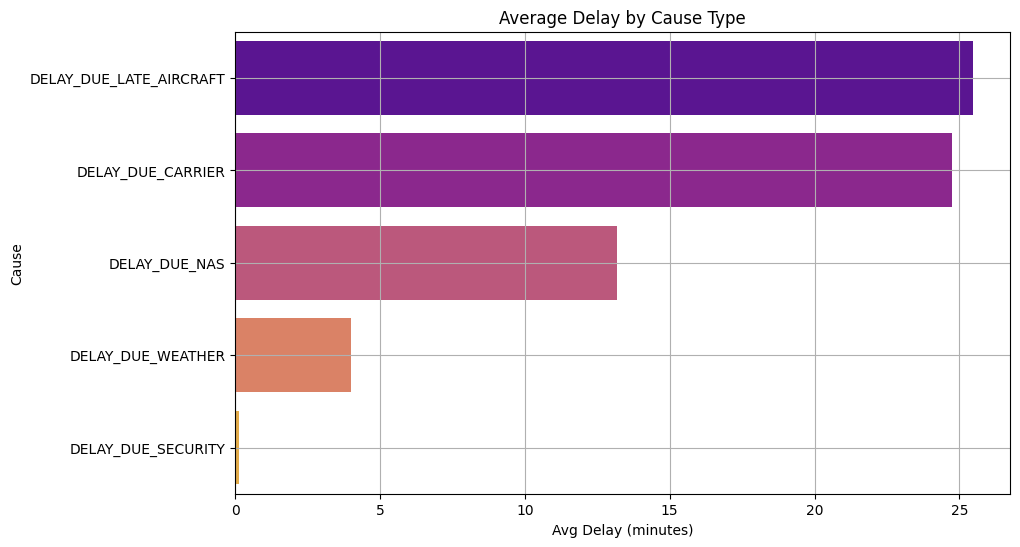

In [ ]:
cause_cols = ['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']
delay_causes = df[cause_cols].mean().sort_values(ascending=False).reset_index()
delay_causes.columns = ['Cause', 'AverageDelay']
plt.figure(figsize=(10, 6))
sns.barplot(x='AverageDelay', y='Cause', data=delay_causes, palette='plasma')
plt.title('Average Delay by Cause Type')
plt.xlabel('Avg Delay (minutes)')
plt.ylabel('Cause')
plt.grid(True)
plt.show()

🇳    Delay Caused by Late Aircraft

/tmp/ipython-input-473513619.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DELAY_DUE_LATE_AIRCRAFT', y='AIRLINE_CODE', data=late_aircraft, palette='OrRd')


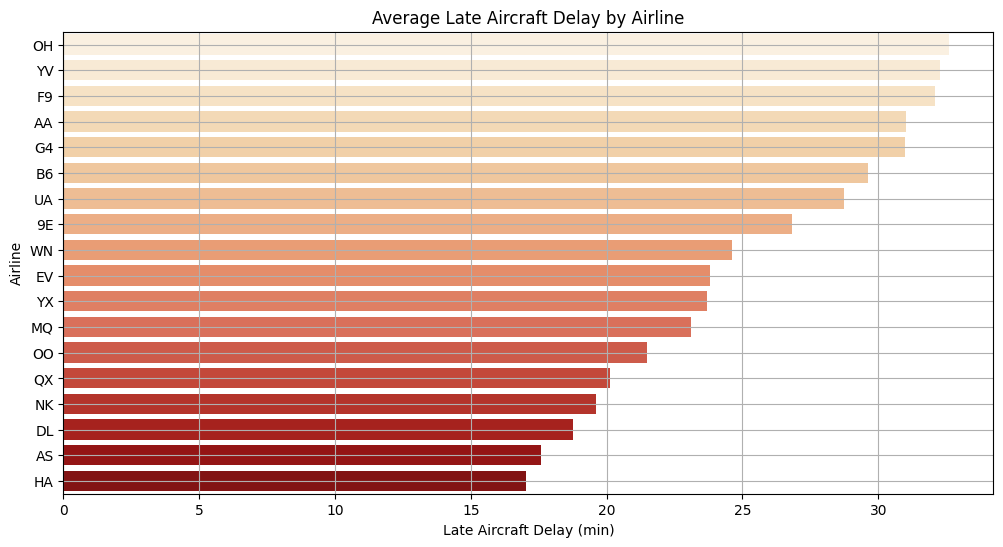

In [ ]:
late_aircraft = df.groupby('AIRLINE_CODE')['DELAY_DUE_LATE_AIRCRAFT'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='DELAY_DUE_LATE_AIRCRAFT', y='AIRLINE_CODE', data=late_aircraft, palette='OrRd')
plt.title('Average Late Aircraft Delay by Airline')
plt.xlabel('Late Aircraft Delay (min)')
plt.ylabel('Airline')
plt.grid(True)
plt.show()

# **🦩   Count of Flights Delayed Over 3 Hours**

/tmp/ipython-input-3493194897.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Airline', data=extreme_count, palette='coolwarm')


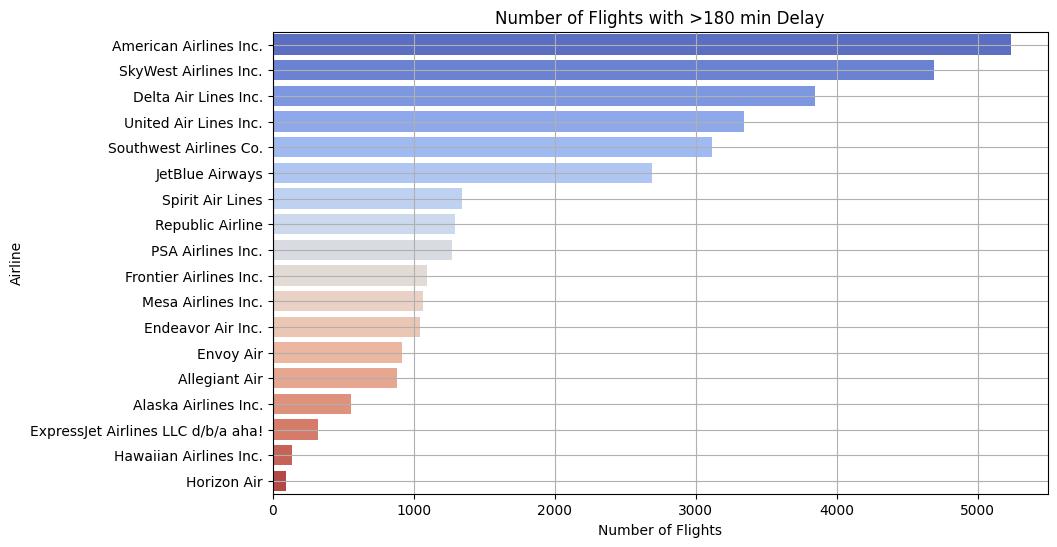

In [ ]:
extreme_delay = df[df['DEP_DELAY'] > 180]
extreme_count = extreme_delay['AIRLINE'].value_counts().reset_index()
extreme_count.columns = ['Airline', 'Count']
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Airline', data=extreme_count, palette='coolwarm')
plt.title('Number of Flights with >180 min Delay')
plt.xlabel('Number of Flights')
plt.ylabel('Airline')
plt.grid(True)
plt.show()

⏰ SUMMARY STATİSTİCS OF ALL DELAY TYPES


In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 3000000
Variables: 39
cat_cols: 9
num_cols: 23
cat_but_car: 7
num_but_cat: 5


In [ ]:
df[num_cols].describe().T

,count,mean,min,25%,50%,75%,max,std
FL_DATE,3000000,2021-05-07 18:03:59.616002048,2019-01-01 00:00:00,2019-12-28 00:00:00,2021-06-28 00:00:00,2022-08-02 00:00:00,2023-08-31 00:00:00,NaN
DOT_CODE,3000000.0,19976.294095,19393.0,19790.0,19930.0,20368.0,20452.0,377.284619
FL_NUMBER,3000000.0,2511.535519,1.0,1051.0,2152.0,3797.0,9562.0,1747.25804
DEP_TIME,2922385.0,1329.775913,1.0,916.0,1323.0,1739.0,2400.0,499.310052
DEP_DELAY,2922356.0,10.123326,-90.0,-6.0,-2.0,6.0,2966.0,49.251835
TAXI_OUT,2921194.0,16.643046,1.0,11.0,14.0,19.0,184.0,9.192901
WHEELS_OFF,2921194.0,1352.360989,1.0,931.0,1336.0,1752.0,2400.0,500.872687
WHEELS_ON,2920056.0,1462.499569,1.0,1049.0,1501.0,1908.0,2400.0,527.236818
TAXI_IN,2920056.0,7.678982,1.0,4.0,6.0,9.0,249.0,6.269639
CRS_ARR_TIME,3000000.0,1490.560665,1.0,1107.0,1516.0,1919.0,2400.0,511.547566


# ▶  ADVANCE MACHINE LEARNING ON FLIGHT DELAY DATASET

## ⚓   Step 1 – Data Preparation for Binary Classification

In [ ]:
cat_cols


['AIRLINE',
 'AIRLINE_DOT',
 'AIRLINE_CODE',
 'CANCELLATION_CODE',
 'CANCELLED',
 'DIVERTED',
 'YEAR',
 'MONTH',
 'DAYOFWEEK']

In [ ]:
df.ROUTE.nunique()

7785

In [ ]:
df_ml = df.copy()

In [ ]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 39 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   FL_DATE                  datetime64[ns]
 1   AIRLINE                  object        
 2   AIRLINE_DOT              object        
 3   AIRLINE_CODE             object        
 4   DOT_CODE                 int64         
 5   FL_NUMBER                int64         
 6   ORIGIN                   object        
 7   ORIGIN_CITY              object        
 8   DEST                     object        
 9   DEST_CITY                object        
 10  CRS_DEP_TIME             object        
 11  DEP_TIME                 float64       
 12  DEP_DELAY                float64       
 13  TAXI_OUT                 float64       
 14  WHEELS_OFF               float64       
 15  WHEELS_ON                float64       
 16  TAXI_IN                  float64       
 17  CRS_ARR_TIME             in

In [ ]:
df = df_ml[
    ['AIRLINE_CODE',  # airline code
     'ORIGIN', 'DEST',
     'CRS_DEP_TIME', 'DAYOFWEEK', 'MONTH','YEAR',
     'DEP_DELAY']
 ].dropna()

In [ ]:
 # Target: 1 if arrival delay > 15 minutes
df_ml['Is_Delayed'] = (df_ml['DEP_DELAY'] > 15).astype(int)

In [ ]:
df_ml.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DEP_HOUR,DEP_MIN,YEAR,MONTH,DAYOFWEEK,ROUTE,TIMEBLOCK,Is_Delayed
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",11:55:00,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,NaN,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN,11,55,2019,1,2,FLL_EWR,11:00-11:59,0
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",21:20:00,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,NaN,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN,21,20,2022,11,5,MSP_SEA,21:00-21:59,0
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",09:54:00,1000.0,6.0,20.0,1020.0,1247.0,5.0,1252,1252.0,0.0,0.0,NaN,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN,9,54,2022,7,4,DEN_MSP,09:00-09:59,0
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",16:09:00,1608.0,-1.0,27.0,1635.0,1844.0,9.0,1829,1853.0,24.0,0.0,NaN,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0,16,9,2023,3,0,MSP_SFO,16:00-16:59,0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",18:40:00,1838.0,-2.0,15.0,1853.0,2026.0,14.0,2041,2040.0,-1.0,0.0,NaN,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN,18,40,2020,2,6,MCO_DFW,18:00-18:59,0


In [ ]:
from sklearn.model_selection import train_test_split

# Veri setinin %30'unu alt örnekleme yapıyoruz
df_ml, _ = train_test_split(
    df_ml,
    train_size=0.3,            # %30'luk bir örnek
    stratify=df_ml['Is_Delayed'],  # sınıf dengesini korumak için
    random_state=42
)

print("Yeni veri seti boyutu:", df_ml.shape)
print("Hedef değişken dağılımı:\n", df_ml['Is_Delayed'].value_counts(normalize=True))


Yeni veri seti boyutu: (900000, 40)
Hedef değişken dağılımı:
 Is_Delayed
0    0.828727
1    0.171273
Name: proportion, dtype: float64


In [ ]:
# 1. Sütunu datetime tipine çeviriyoruz
df_ml['CRS_DEP_TIME'] = pd.to_datetime(df_ml['CRS_DEP_TIME'], format='%H:%M:%S')

# 2. Saat bilgisini çıkarıyoruz
df_ml['DEP_HOUR'] = df_ml['CRS_DEP_TIME'].dt.hour



In [ ]:
# Label-encode categorical features
encoders = {
    'Airline_encoded': LabelEncoder(),
    'Origin_encoded' : LabelEncoder(),
    'Dest_encoded'   : LabelEncoder()
 }
df_ml['Airline_encoded'] = encoders['Airline_encoded'].fit_transform(df_ml['AIRLINE_CODE'])
df_ml['Origin_encoded']  = encoders['Origin_encoded'].fit_transform(df_ml['ORIGIN'])
df_ml['Dest_encoded']    = encoders['Dest_encoded'].fit_transform(df_ml['DEST'])
 # Final feature matrix and target vector
features = ['Airline_encoded', 'Origin_encoded', 'Dest_encoded',
            'DEP_HOUR', 'DAYOFWEEK', 'MONTH','YEAR']
X = df_ml[features]
y = df_ml['Is_Delayed']
 # Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "| Test size:", X_test.shape)

Train size: (720000, 7) | Test size: (180000, 7)


## ▶   Step 2 – Check Column Names and Data Types In this step, we inspect the dataset's structure by printing its columns and data types.
 This helps identify any unexpected or mixed types, and ensures we’re working with clean, usable data.

In [ ]:
for col in df_ml.select_dtypes(include='object').columns:
    print(f"{col}: {df_ml[col].nunique()} unique values")

AIRLINE: 18 unique values
AIRLINE_DOT: 18 unique values
AIRLINE_CODE: 18 unique values
ORIGIN: 380 unique values
ORIGIN_CITY: 373 unique values
DEST: 380 unique values
DEST_CITY: 373 unique values
CANCELLATION_CODE: 4 unique values
ROUTE: 7520 unique values
TIMEBLOCK: 24 unique values


In [ ]:
df_ml.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DEP_HOUR,DEP_MIN,YEAR,MONTH,DAYOFWEEK,ROUTE,TIMEBLOCK,Is_Delayed,Airline_encoded,Origin_encoded,Dest_encoded
2886333,2022-04-23,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,5415,ORD,"Chicago, IL",OKC,"Oklahoma City, OK",1900-01-01 08:50:00,850.0,0.0,32.0,922.0,1109.0,5.0,1107,1114.0,7.0,0.0,NaN,0.0,137.0,144.0,107.0,693.0,NaN,NaN,NaN,NaN,NaN,8,50,2022,4,5,ORD_OKC,08:00-08:59,0,12,261,257
825913,2023-07-19,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,493,CLE,"Cleveland, OH",IAD,"Washington, DC",1900-01-01 06:18:00,616.0,-2.0,14.0,630.0,719.0,11.0,732,730.0,-2.0,0.0,NaN,0.0,74.0,74.0,49.0,288.0,NaN,NaN,NaN,NaN,NaN,6,18,2023,7,2,CLE_IAD,06:00-06:59,0,14,75,172
2420535,2022-08-19,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,2399,SMF,"Sacramento, CA",LAS,"Las Vegas, NV",1900-01-01 09:10:00,910.0,0.0,8.0,918.0,1017.0,14.0,1030,1031.0,1.0,0.0,NaN,0.0,80.0,81.0,59.0,397.0,NaN,NaN,NaN,NaN,NaN,9,10,2022,8,4,SMF_LAS,09:00-09:59,0,15,337,199
1718190,2023-07-25,Republic Airline,Republic Airline: YX,YX,20452,4281,CVG,"Cincinnati, OH",BOS,"Boston, MA",1900-01-01 17:25:00,NaN,NaN,NaN,NaN,NaN,NaN,1937,NaN,NaN,1.0,C,0.0,132.0,NaN,NaN,752.0,NaN,NaN,NaN,NaN,NaN,17,25,2023,7,1,CVG_BOS,17:00-17:59,0,17,89,49
1873903,2022-02-19,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,2467,LAS,"Las Vegas, NV",TUS,"Tucson, AZ",1900-01-01 14:25:00,1428.0,3.0,13.0,1441.0,1634.0,3.0,1650,1637.0,-13.0,0.0,NaN,0.0,85.0,69.0,53.0,365.0,NaN,NaN,NaN,NaN,NaN,14,25,2022,2,5,LAS_TUS,14:00-14:59,0,15,199,361


In [ ]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 2886333 to 2142588
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   FL_DATE                  900000 non-null  datetime64[ns]
 1   AIRLINE                  900000 non-null  object        
 2   AIRLINE_DOT              900000 non-null  object        
 3   AIRLINE_CODE             900000 non-null  object        
 4   DOT_CODE                 900000 non-null  int64         
 5   FL_NUMBER                900000 non-null  int64         
 6   ORIGIN                   900000 non-null  object        
 7   ORIGIN_CITY              900000 non-null  object        
 8   DEST                     900000 non-null  object        
 9   DEST_CITY                900000 non-null  object        
 10  CRS_DEP_TIME             900000 non-null  datetime64[ns]
 11  DEP_TIME                 876565 non-null  float64       
 12  DEP_DELAY     

In [ ]:
X_train

,Airline_encoded,Origin_encoded,Dest_encoded,DEP_HOUR,DAYOFWEEK,MONTH,YEAR
773849,14,261,325,12,5,12,2022
2312348,2,193,19,7,2,6,2022
861142,0,210,77,20,0,1,2020
657549,14,123,108,21,0,5,2023
2662795,4,300,49,16,4,6,2023
...,...,...,...,...,...,...,...
184006,17,123,124,17,0,1,2020
2920435,14,123,270,14,1,11,2019
415065,4,337,23,12,6,8,2022
1787490,9,121,100,17,2,5,2022


## ▶  Step 3 – Training Random Forest and XGBoost Classifiers

In [ ]:
##   Step 1 – Train Random Forest and XGBoost Classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

### ➿  1️⃣ Train Random Forest Classifier


In [ ]:
#rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#rf_model.fit(X_train, y_train)
#rf_preds = rf_model.predict(X_test)

### 2️⃣ Train XGBoost Classifier



In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:03:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


3️⃣
 Evaluation Function for Both Models

In [ ]:
def evaluate_model(name, y_true, y_pred):
 print(f"\n  Evaluation for: {name}")
 print("Accuracy:", accuracy_score(y_true, y_pred))
 print("Precision:", precision_score(y_true, y_pred))
 print("Recall:", recall_score(y_true, y_pred))
 print("F1 Score:", f1_score(y_true, y_pred))
 print("Confusion Matrix:")
 cm = confusion_matrix(y_true, y_pred)
 sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
 plt.title(f"{name} - Confusion Matrix")
 plt.xlabel("Predicted")
 plt.ylabel("Actual")
 plt.show()


  Evaluation for: XGBoost
Accuracy: 0.8310611111111111
Precision: 0.5726643598615917
Recall: 0.05368322034448084
F1 Score: 0.0981642397461372
Confusion Matrix:


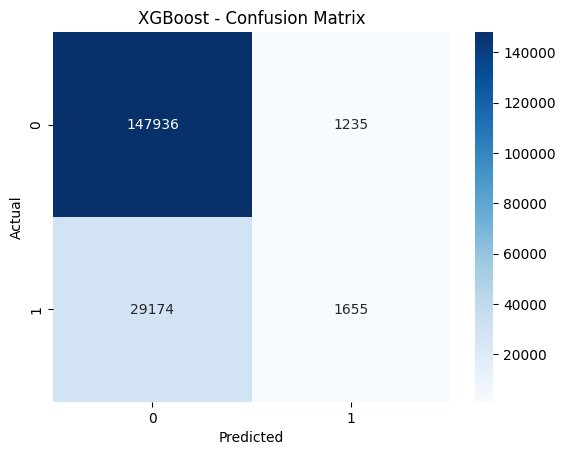

In [ ]:
# evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)

# Adım 1 — SMOTE Kütüphanesini Kurma

In [ ]:
pip install imbalanced-learn

# Adım 2 — SMOTE Uygulama

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter



In [ ]:
# Eğitim setinde sınıf dengesine bakalım
print("Önce:", Counter(y_train))

Önce: Counter({0: 596683, 1: 123317})


In [ ]:
# SMOTE uygulama
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
print("Sonra:", Counter(y_train_res))

Sonra: Counter({1: 596683, 0: 596683})


# Adım 3 — XGBoost’u SMOTE Sonrası Tekrar Eğitme

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Modeli yeniden eğit
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Test seti üzerinde tahminler
y_pred = xgb_model.predict(X_test)

In [ ]:
# Sonuçları değerlendirme
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.68      0.77    149171
           1       0.26      0.55      0.35     30829

    accuracy                           0.66    180000
   macro avg       0.57      0.61      0.56    180000
weighted avg       0.77      0.66      0.69    180000

[[101219  47952]
 [ 14017  16812]]


sonrası 

  Evaluation for: XGBoost
Accuracy: 0.6557277777777778
Precision: 0.2595886603668705
Recall: 0.5453306951247202
F1 Score: 0.3517412362829914
Confusion Matrix:


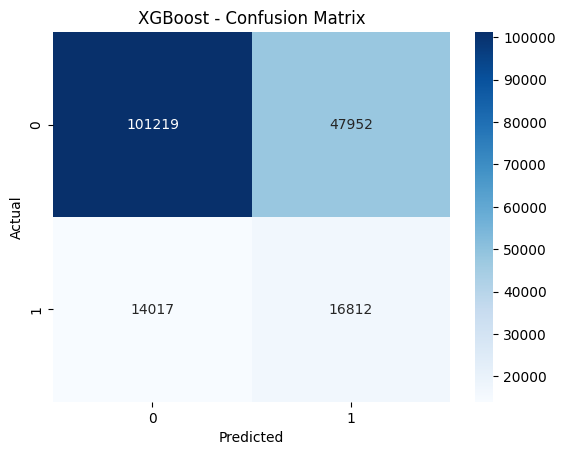

In [ ]:
print("sonrası ")
evaluate_model("XGBoost", y_test, y_pred)

# XGBoost hiperparametre optimizasyonu

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Model tanımı
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

In [ ]:
# Hiperparametre aralığı
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [1, 3, 5, 10]  # sınıf dengesizliği için
}

In [ ]:
# RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=30,                 # 30 deneme ile optimize ederiz
    scoring='f1',              # F1 skoru optimize edilecek
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [ ]:
# Modeli eğit
xgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:15:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 200, 500],
                                        'scale_pos_weight': [1, 3, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1', verbose=2)

In [ ]:
# En iyi parametreler
print("En iyi parametreler:", xgb_random.best_params_)
print("En iyi F1 skoru:", xgb_random.best_score_)

En iyi parametreler: {'subsample': 1.0, 'scale_pos_weight': 5, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
En iyi F1 skoru: 0.3853598394271367


In [ ]:
# 1) Best params sözlüğünü buraya yapıştır
best_params = {
    'subsample': 1.0,
    'scale_pos_weight': 3, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6
}


In [ ]:

# 2) Modeli kur ve eğit
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    **best_params
)

xgb.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:15:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:

# 3) Tahmin
y_proba = xgb.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.50).astype(int)   # threshold'u sonra optimize ederiz


In [ ]:

# 4) Değerlendirme
print("Classification report:\n", classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Classification report:
               precision    recall  f1-score   support

           0      0.874     0.847     0.860    149171
           1      0.354     0.407     0.379     30829

    accuracy                          0.771    180000
   macro avg      0.614     0.627     0.619    180000
weighted avg      0.785     0.771     0.778    180000

Confusion matrix:
 [[126290  22881]
 [ 18271  12558]]
ROC-AUC: 0.7092572781447227


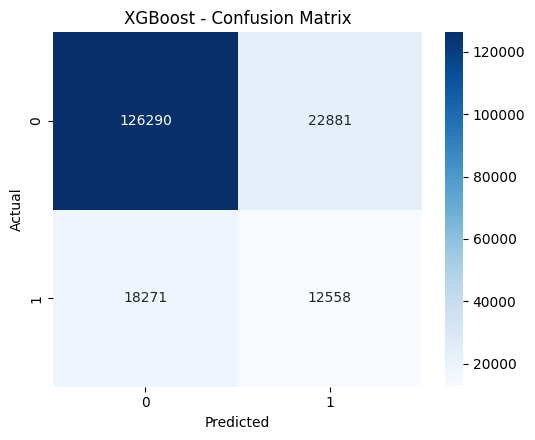

In [ ]:

# 5) Confusion matrix görselleştirme
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5.5,4.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [ ]:
best_xgb = XGBClassifier(**best_params)  # en iyi parametrelerle model oluşturuluyor
best_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

1. ROC Eğrisi ve Olasılıkların Tahmin Edilmes

In [ ]:
from sklearn.metrics import roc_curve

# XGBoost modelinden olasılık tahminleri
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# ROC eğrisi için değerleri hesapla
fpr, tpr, thresholds = roc_curve(y_test, y_probs)


2. ROC Eğrisi için Doğru Kod

In [ ]:
from sklearn.metrics import roc_curve

# Olasılık tahminlerini al
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# ROC eğrisi değerlerini hesapla
fpr, tpr, thresholds = roc_curve(y_test, y_probs)


3. ROC Eğrisi Çizimi

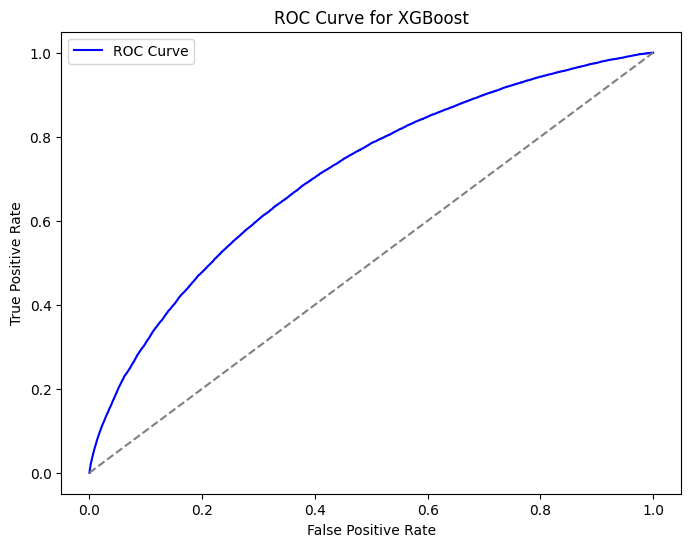

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import (
    precision_recall_curve, roc_curve, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)

def find_best_threshold(y_true, y_prob, method="f1", target_recall=None, target_precision=None):
    """
    method:
      - "f1"      : F1 skorunu maksimize eden eşik
      - "youden"  : Youden's J = TPR - FPR maksimize eden eşik (ROC tabanlı)
      - "recall_at_precision": Belirlenen precision üzerinde en yüksek recall'u veren eşik
      - "precision_at_recall": Belirlenen recall üzerinde en yüksek precision'u veren eşik
    """
    if method == "f1":
        prec, rec, thr = precision_recall_curve(y_true, y_prob)
        # precision_recall_curve thresholds uzunluğu n-1’dir → son eleman için eşik ekleyelim
        thr = np.r_[thr, 1.0]
        f1 = 2 * prec * rec / (prec + rec + 1e-12)
        t_best = thr[np.nanargmax(f1)]
        return t_best, {"best_f1": np.nanmax(f1)}

    elif method == "youden":
        fpr, tpr, thr = roc_curve(y_true, y_prob)
        j = tpr - fpr
        t_best = thr[np.argmax(j)]
        return t_best, {"best_J": np.max(j)}

    elif method == "recall_at_precision":
        assert target_precision is not None, "target_precision belirtin (örn. 0.5)"
        prec, rec, thr = precision_recall_curve(y_true, y_prob)
        thr = np.r_[thr, 1.0]
        mask = prec >= target_precision
        if not np.any(mask):
            # hedef precision sağlanamıyorsa en yüksek precision’lı eşiği ver
            idx = np.argmax(prec)
        else:
            idx = np.argmax(rec[mask])
            idx = np.arange(len(prec))[mask][idx]
        return thr[idx], {"precision": prec[idx], "recall": rec[idx]}

    elif method == "precision_at_recall":
        assert target_recall is not None, "target_recall belirtin (örn. 0.6)"
        prec, rec, thr = precision_recall_curve(y_true, y_prob)
        thr = np.r_[thr, 1.0]
        mask = rec >= target_recall
        if not np.any(mask):
            idx = np.argmax(rec)
        else:
            idx = np.argmax(prec[mask])
            idx = np.arange(len(prec))[mask][idx]
        return thr[idx], {"precision": prec[idx], "recall": rec[idx]}

    else:
        raise ValueError("method ['f1','youden','recall_at_precision','precision_at_recall'] olmalı.")


In [ ]:
# 1) Model olasılıkları
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# 2) F1'i maksimize eden eşik
t_f1, info_f1 = find_best_threshold(y_test, y_prob, method="f1")
print(f"F1 maks için en iyi threshold: {t_f1:.3f} | info: {info_f1}")

# Alternatif: Youden's J
t_j, info_j = find_best_threshold(y_test, y_prob, method="youden")
print(f"Youden J için en iyi threshold: {t_j:.3f} | info: {info_j}")

# Alternatif: belirli precision hedefiyle en yüksek recall
# t_p, info_p = find_best_threshold(y_test, y_prob, method="recall_at_precision", target_precision=0.50)
# print(f\"Precision≥0.50 için threshold: {t_p:.3f} | info: {info_p}\")


F1 maks için en iyi threshold: 0.422 | info: {'best_f1': np.float64(0.39586520187225205)}
Youden J için en iyi threshold: 0.353 | info: {'best_J': np.float64(0.30567269948160763)}



Default threshold = 0.500
              precision    recall  f1-score   support

           0      0.873     0.847     0.860    149171
           1      0.354     0.406     0.378     30829

    accuracy                          0.771    180000
   macro avg      0.614     0.626     0.619    180000
weighted avg      0.784     0.771     0.777    180000

Confusion matrix:
 [[126311  22860]
 [ 18316  12513]]
ROC-AUC: 0.7088957937101944


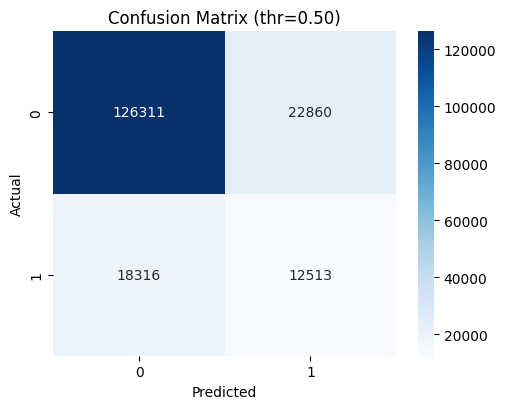


Best F1 threshold = 0.422
              precision    recall  f1-score   support

           0      0.890     0.743     0.810    149171
           1      0.308     0.554     0.396     30829

    accuracy                          0.710    180000
   macro avg      0.599     0.648     0.603    180000
weighted avg      0.790     0.710     0.739    180000

Confusion matrix:
 [[110788  38383]
 [ 13749  17080]]
ROC-AUC: 0.7088957937101944


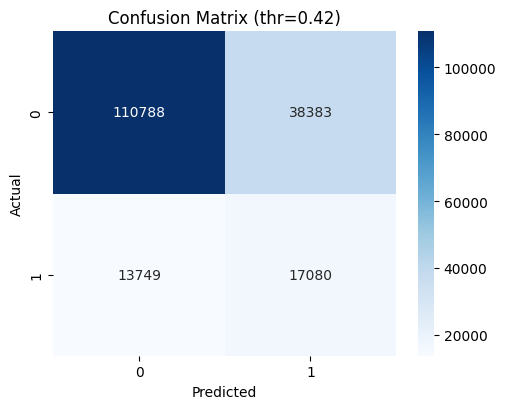

In [ ]:
def evaluate_with_threshold(y_true, y_prob, threshold, title="Model @ threshold"):
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\n{title} = {threshold:.3f}")
    print(classification_report(y_true, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))

    # Confusion matrix görseli
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5.2,4.2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix (thr={threshold:.2f})")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

# Varsayılan 0.50 ile ve yeni eşikle karşılaştır
evaluate_with_threshold(y_test, y_prob, 0.50, "Default threshold")
evaluate_with_threshold(y_test, y_prob, t_f1, "Best F1 threshold")

# İstersen Youden J ile de bak
# evaluate_with_threshold(y_test, y_prob, t_j, "Best Youden J threshold")


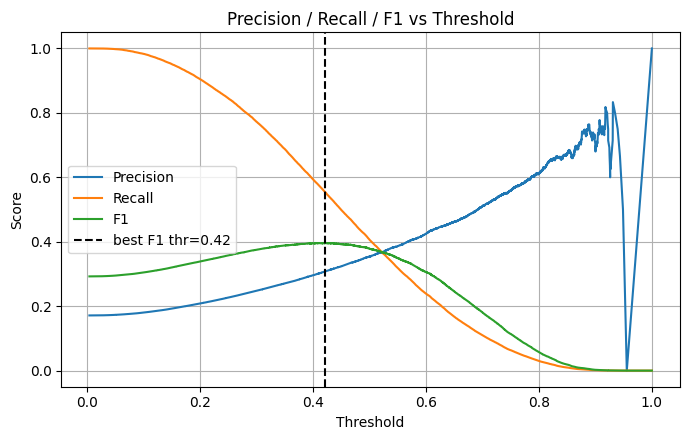

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, y_prob)
thr = np.r_[thr, 1.0]
f1 = 2*prec*rec/(prec+rec+1e-12)

plt.figure(figsize=(7,4.5))
plt.plot(thr, prec, label="Precision")
plt.plot(thr, rec,  label="Recall")
plt.plot(thr, f1,   label="F1")
plt.axvline(t_f1, color="k", ls="--", label=f"best F1 thr={t_f1:.2f}")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


/tmp/ipython-input-3309755153.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x="Importance", y="Feature", palette="viridis")


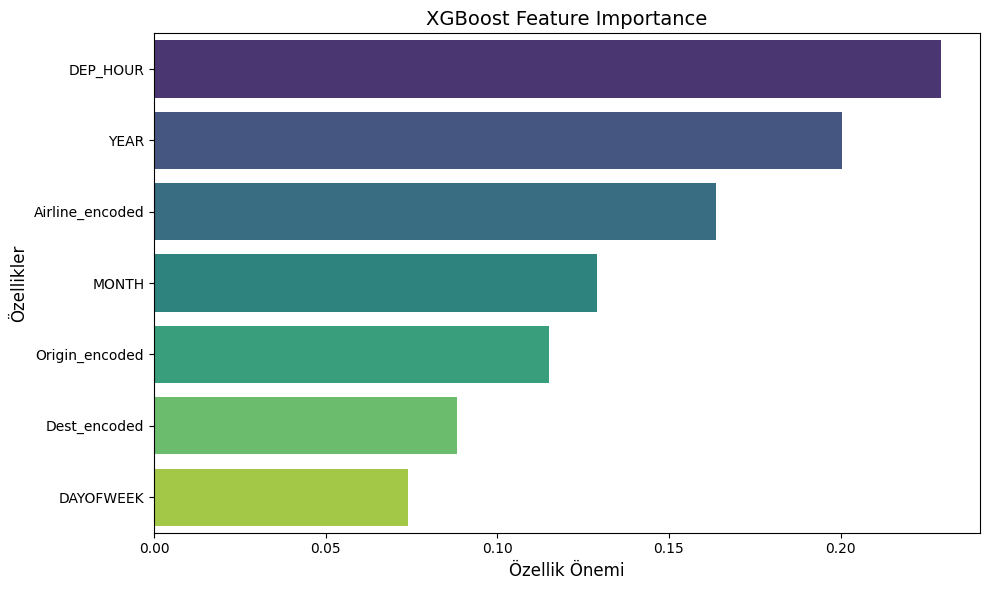

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Özellik önemlerini al
feature_importance = best_xgb.feature_importances_

# DataFrame'e dönüştür
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# En önemli 20 özelliği görselleştirelim
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x="Importance", y="Feature", palette="viridis")
plt.title("XGBoost Feature Importance", fontsize=14)
plt.xlabel("Özellik Önemi", fontsize=12)
plt.ylabel("Özellikler", fontsize=12)
plt.tight_layout()
plt.show()

# İstersen tüm özellikleri görmek için:
# display(importance_df)


# **1. SHAP Kurulumu ve Değerleri Hesaplama**

In [ ]:
import shap

# SHAP değerlerini hesaplamak için explainer oluştur
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)


# **2. Genel Özellik Önemini Görselleştirme**

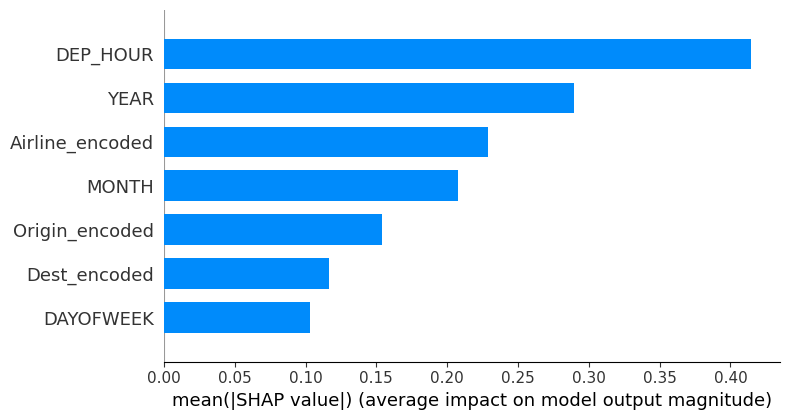

In [ ]:
# SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


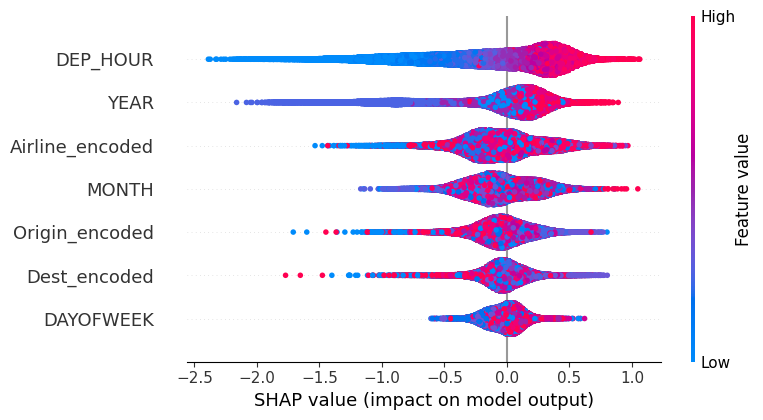

In [ ]:
# Özelliklerin hedef değişkene etkisini görselleştirme
shap.summary_plot(shap_values, X_test)
